Превью интерактивной карты показывается не во всех браузерах (ipynb и html). В Chrome работает.

# 1. Загрузка данных
Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [1]:
import pandas as pd
from scipy.stats import binned_statistic_2d
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pandas import DataFrame
import matplotlib.colors as colors
%matplotlib inline

# Загружаем регионы

regions = pd.read_csv('regions.csv', ';')

x_bins = np.sort(np.unique(np.concatenate([regions.east, regions.west])))
y_bins = np.sort(np.unique(np.concatenate([regions.north, regions.south])))

# Загружаем данные

data = pd.read_csv('d:/ml/data/yellow_tripdata_2016-05.csv', #nrows = 10000,
                   parse_dates=['tpep_dropoff_datetime', 'tpep_pickup_datetime'])

# Фильтруем

# Границы города
X0, X1, Y0, Y1 = -74.25559, -73.70001, 40.49612, 40.91553

# Условие выхода за пределы города
outbound  = data.pickup_longitude < X0
outbound |= data.pickup_longitude > X1
outbound |= data.pickup_latitude < Y0
outbound |= data.pickup_latitude > Y1

# Время поездки
duration = data.tpep_dropoff_datetime - data.tpep_pickup_datetime

# Удаление неподходящих строк
drop_condition = (duration == pd.Timedelta(0)) | (data.passenger_count == 0) | (data.trip_distance == 0) | outbound
drop_indices = data[drop_condition].index
data.drop(drop_indices, inplace = True)

In [2]:
# Суммируем для каждого региона
regions_count = binned_statistic_2d(data.pickup_longitude, data.pickup_latitude,
                                    None, 'count', bins=(x_bins, y_bins)).statistic

# Находим количество регионов без поездок
np.size(regions_count) - np.count_nonzero(regions_count)

1283

# 2, 3. Статическая карта
* 2) Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.

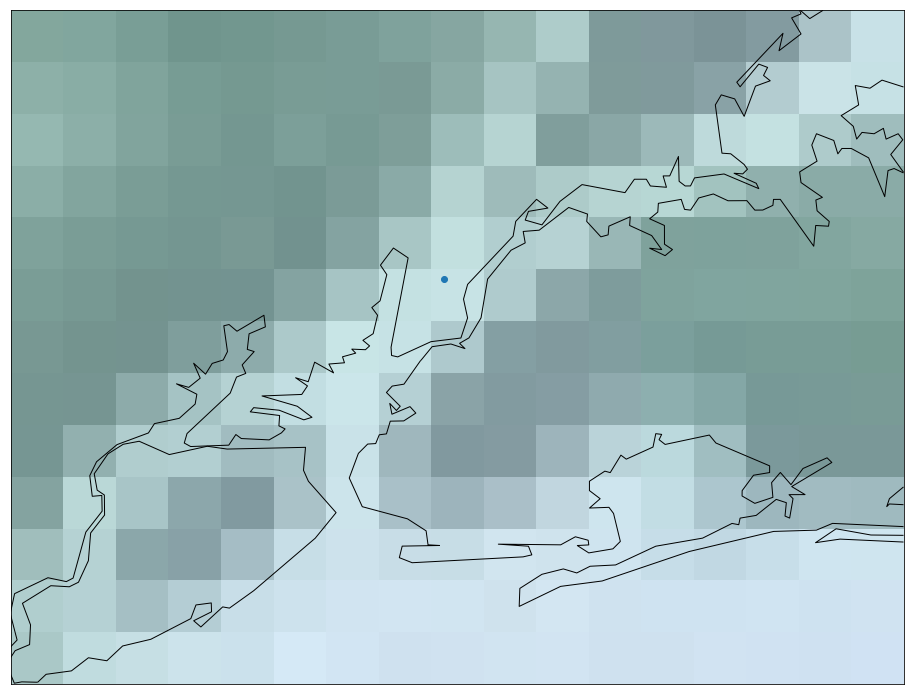

In [3]:
# Границы города
X0, X1, Y0, Y1 = -74.25559, -73.70001, 40.49612, 40.91553

plt.figure(figsize=(16,16))

m = Basemap(llcrnrlon = X0, llcrnrlat = Y0, urcrnrlon = X1, urcrnrlat = Y1, resolution='h')
m.shadedrelief()
m.drawcoastlines()

# Добавляем отметку с Empire State Building
esb_long, esb_lat = -73.985656, 40.748433
m.scatter([esb_long], [esb_lat])

* 3) Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

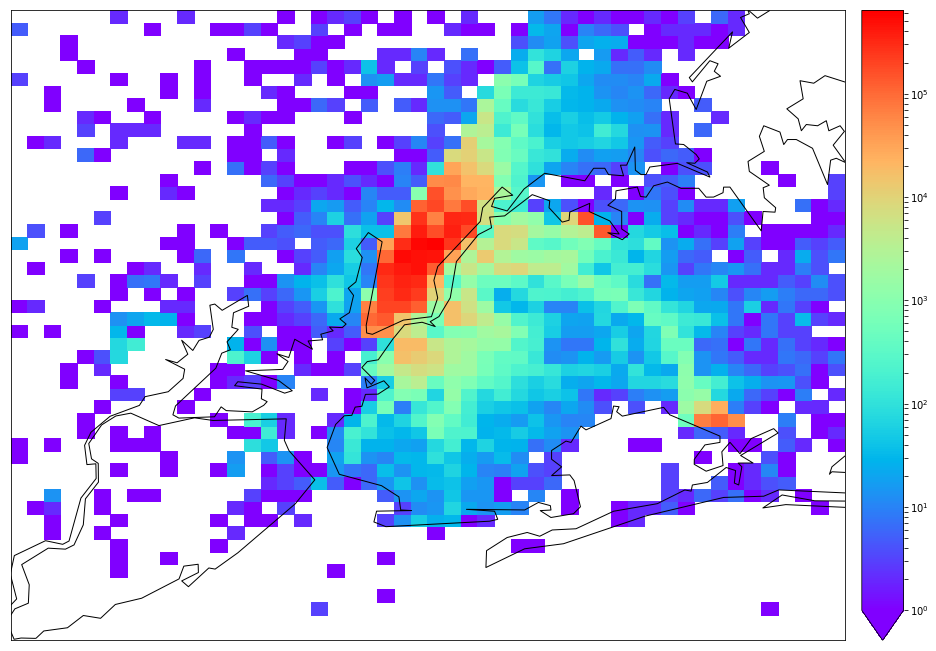

In [4]:
# Цветовая шкала логарифмическая!

plt.figure(figsize=(16,16))

m = Basemap(llcrnrlon = X0, llcrnrlat = Y0, urcrnrlon = X1, urcrnrlat = Y1, resolution='h')
m.drawcoastlines()

my_cmap = plt.get_cmap('rainbow')
cs = m.pcolormesh(x_bins,
                  y_bins,
                  np.transpose(regions_count),
                  cmap = my_cmap,
                  norm=colors.LogNorm(vmin=1, vmax=regions_count.max()))
m.colorbar(cs, extend = 'min')

plt.show()

# 4, 5. Интерактивная карта

Для интерактивной карты был использован folium, а также формат geojson. Для установки в Anaconda:

    conda install -c conda-forge geojson
    conda install -c conda-forge folium

* 4) Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [5]:
from geojson import (Polygon, FeatureCollection, Feature)
import folium
import matplotlib
    
# Создаем карту
center = [(Y0 + Y1) / 2, (X0 + X1) / 2]
m = folium.Map(location=center, zoom_start=10)

# Добавляем маркер со статуей свободы
folium.Marker([40.689247, -74.044502], u'Статуя свободы').add_to(m)

m

* 5) Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [6]:
# Создаем карту
m = folium.Map(location=center, zoom_start=10)

# Формируем список регионов в формате geojson
rect_list = []
for index, row in regions.iterrows():

    y0, x0, y1, x1 = row['south'], row['east'], row['north'], row['west']
    p = Polygon([[(x0, y0), (x0, y1), (x1, y1), (x1, y0)]], properties = {"index": int(index)})
    f = Feature(geometry=p, id=int(index))
    rect_list.append(f)

# Создаем коллекцию на основе списка регионов
fc = FeatureCollection(rect_list)

cmap = matplotlib.cm.get_cmap('coolwarm')
max_count = regions_count.max()
log_norm = colors.LogNorm(vmin=1, vmax=max_count)

# Функция, возвращающая цвет региона
def color_function(feature):
    region_id = feature.id

    trips = regions_count[region_id / 50, region_id % 50]
    if trips == 0:
        return cmap(0)
    
    rgba = cmap(log_norm(trips))
    hex = '#%02x%02x%02x' % (rgba[0] * 256, rgba[1] * 256, rgba[2] * 256)
    return hex

# Помещаем коллекцию на карту
folium.GeoJson(
    fc, 
    style_function=lambda feature: {
        'fillColor': color_function(feature),
        'color': 'black',
        'weight': 0.1,
        'fillOpacity': 0.5,
    }
).add_to(m)

m

# 6. Фильтрация редких поездок

In [7]:
# Фильтруем поездки

def filter_rare_trips(x):
    return x if (float(x) / (31 * 24)) >= 5 else 0

regions_count = np.vectorize(filter_rare_trips)(regions_count)

# Вычисляем количество ненулевых 
np.count_nonzero(regions_count)

102

In [8]:
# Еще раз создаем карту, она будет использовать уже фильтрованный массив regions_count
m